In [1]:
from fastai.tabular.all import *
from warnings import simplefilter
import dataframe_image as dfi
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

In [184]:
df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
#print(df['Pathway(ConsensusPathDB)'].apply(lambda x: len(x) if type(x) is list else list()))
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        #print(df[col])
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index
    df[col] = df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

df_ex = pd.DataFrame.from_dict(dict, orient='index')
df_ex.columns = ['Valori unici', 'Esempi']
print(df_ex)

df.drop(['Function_description', 'Disease_description', 'HPO_id', 'HPO_name', 'MGI_mouse_phenotype'], axis=1, inplace=True)
dict.pop('Function_description')
dict.pop('Disease_description')
dict.pop('HPO_id')
dict.pop('HPO_name')
dict.pop('MGI_mouse_phenotype')

for key, value in dict.items():
    if value['Valori unici'] > 10:
        df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            df[c] = df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        df.drop(key, axis=1, inplace=True)
        

#dfi.export(df_ex, 'df_ex.png', table_conversion = "matplotlib")
#print(l1)
#MutationTaster_score and MGI_mouse_phenotype
#df['MutationTaster_score'] = df['MutationTaster_score'].apply(lambda x: np.mean([float(numeric_string) for numeric_string in x]) if type(x) is list else x)
#v = sorted(df['MGI_mouse_phenotype'].explode().unique())
#for c in v:
    #df[c] = df['MGI_mouse_phenotype'].apply(lambda lis: int(c in lis))
#df.drop(['MGI_mouse_phenotype', ' '], axis=1, inplace=True)

/tmp/ipykernel_660/2980609535.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


                           Valori unici  \
MutationTaster_score                509   
MutationTaster_pred                   5   
MutationTaster_model                  4   
MutationTaster_AAE                 1377   
CCDS_id                              53   
Refseq_id                            75   
Pathway(ConsensusPathDB)              8   
Function_description                  2   
Disease_description                   2   
Orphanet_disorder_id                 21   
Orphanet_disorder                    21   
Orphanet_association_type             5   
HPO_id                                1   
HPO_name                              1   
GO_biological_process                 6   
GO_cellular_component                 5   
GO_molecular_function                 8   
MGI_mouse_phenotype                   1   

                                                                                                                                                                                      

In [185]:
#df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
#df.replace(to_replace='.', value=np.nan, inplace=True)
#df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
df.apply(pd.to_numeric, errors='ignore')
df.replace(to_replace=np.nan, value=0, inplace=True)
#df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
#df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df.reset_index(drop=True, inplace=True)
#df.to_csv('test.csv', index=False, sep='\t')

In [140]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [141]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [142]:
dls = to.dataloaders(bs=1024)

In [143]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10))

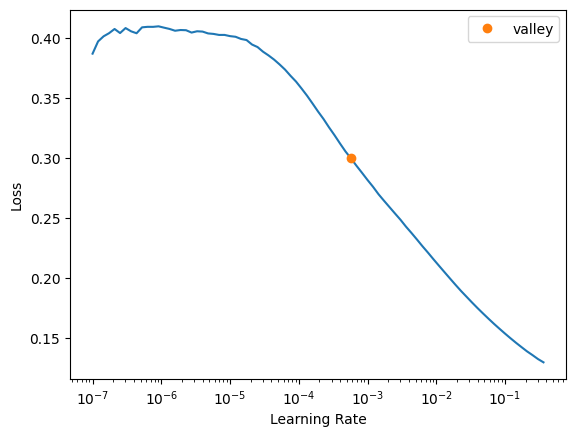

In [144]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.140275,0.115107,0.705803,00:00
1,0.092018,0.075775,0.782288,00:00
2,0.062325,0.040867,0.873868,00:00
3,0.043005,0.021402,0.924522,00:00
4,0.030862,0.018026,0.937940,00:00
5,0.022751,0.018063,0.952030,00:00
6,0.017114,0.017938,0.958739,00:00
7,0.013076,0.016393,0.961087,00:01
8,0.010113,0.018261,0.960416,00:00
9,0.007891,0.017690,0.960751,00:00


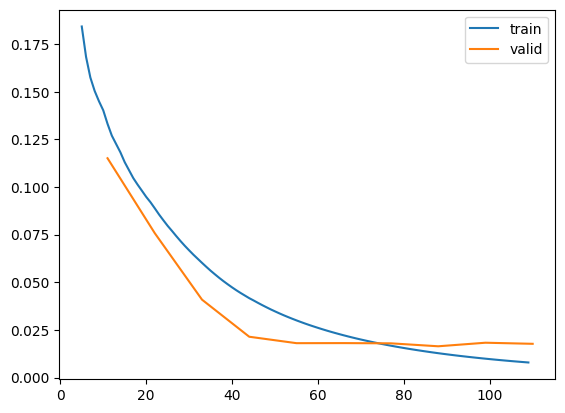

In [145]:
learn.fit(10, 1e-3, wd=0.01)
learn.recorder.plot_loss()

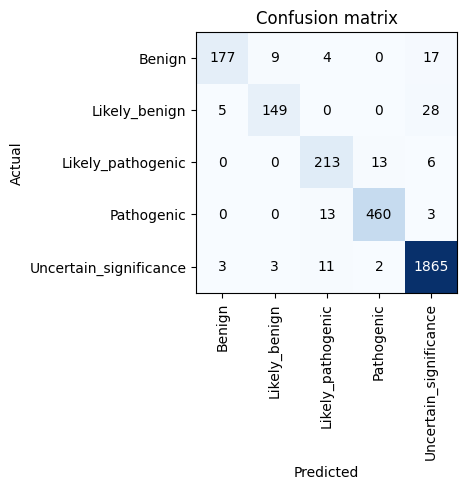

In [146]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [147]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=3328,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
     


In [148]:
xs,y = to.train.xs,to.train.y
m = rf(xs, y)

In [149]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [150]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
84,MetaRNN_score,0.141716
85,MetaRNN_rankscore,0.130942
37,clinvar_review,0.061009
87,M-CAP_rankscore,0.051805
136,clinvar_id,0.048162
86,M-CAP_score,0.038197
94,DEOGEN2_rankscore,0.029200
27,M-CAP_pred,0.028951
76,FATHMM_converted_rankscore,0.022420
93,PrimateAI_rankscore,0.016278


<Axes: ylabel='cols'>

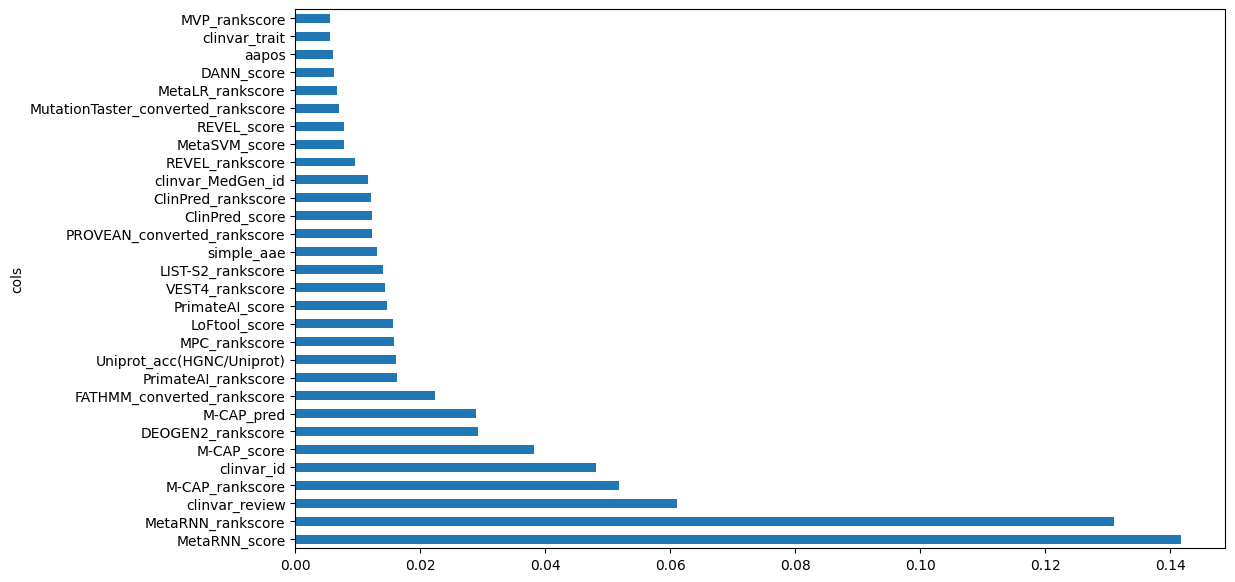

In [151]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [152]:
to_keep = fi[fi.imp>0.005].cols

In [186]:
df_keep = df[to_keep].copy()
df_keep

,MetaRNN_score,MetaRNN_rankscore,clinvar_review,M-CAP_rankscore,clinvar_id,M-CAP_score,DEOGEN2_rankscore,M-CAP_pred,FATHMM_converted_rankscore,PrimateAI_rankscore,...,DANN_score,aapos,clinvar_trait,MVP_rankscore,SIFT4G_converted_rankscore,HGVSc_VEP,ClinPred_pred,hg18_pos(1-based),HGVSp_VEP,rs_dbSNP
0,0.052396,0.05268,"criteria_provided,_single_submitter",0.00000,718788,0.00000,0.00000,0,0.92829,0.54473,...,0.997504,307,not_provided,0.81231,0.92824,c.919T>C,T,14459460,p.Cys307Arg,rs61740029
1,0.052396,0.05268,"criteria_provided,_single_submitter",0.00000,718788,0.00000,0.00000,0,0.92829,0.54473,...,0.997504,277,not_provided,0.81231,0.92824,c.829T>C,T,14459460,p.Cys277Arg,rs61740029
2,0.052396,0.05268,"criteria_provided,_single_submitter",0.00000,718788,0.00000,0.00000,0,0.92829,0.54473,...,0.997504,247,not_provided,0.81231,0.92824,c.739T>C,T,14459460,p.Cys247Arg,rs61740029
3,0.014380,0.00303,no_assertion_criteria_provided,0.00000,1822,0.00000,0.00000,0,0.90332,0.56360,...,0.997764,76,"Hypertriglyceridemia,_susceptibility_to",0.79225,0.92824,c.227G>A,T,14483494,p.Cys76Tyr,rs11909217
4,0.014380,0.00303,no_assertion_criteria_provided,0.00000,1822,0.00000,0.00000,0,0.90332,0.56360,...,0.997764,46,"Hypertriglyceridemia,_susceptibility_to",0.79225,0.92824,c.137G>A,T,14483494,p.Cys46Tyr,rs11909217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,0.004463,0.00092,"criteria_provided,_single_submitter",0.00000,718694,0.00000,0.63483,0,0.21865,0.31256,...,0.996617,251,not_provided,0.22246,0.40586,c.751G>A,T,46906236,p.Gly251Arg,rs142055128
14903,0.018850,0.00414,"criteria_provided,_single_submitter",0.78885,764005,0.11118,0.89985,D,0.64818,0.61963,...,0.997396,366,not_provided,0.46650,0.17320,c.1096C>A,T,46906275,p.Pro366Thr,rs199822008
14904,0.018850,0.00414,"criteria_provided,_single_submitter",0.78885,764005,0.11118,0.89985,D,0.64818,0.61963,...,0.997396,366,not_provided,0.46650,0.17320,c.1096C>A,T,46906275,p.Pro366Thr,rs199822008
14905,0.018850,0.00414,"criteria_provided,_single_submitter",0.78885,764005,0.11118,0.89985,D,0.64818,0.61963,...,0.997396,366,not_provided,0.46650,0.17320,c.1096C>A,T,46906275,p.Pro366Thr,rs199822008


In [187]:
num_cols = df_keep.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_keep.select_dtypes(include=[object]).columns.tolist()
df = pd.concat([df['clinvar_clnsig'], df_keep], axis=1)
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [188]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [189]:
dls = to.dataloaders(bs=1024)

In [190]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10))

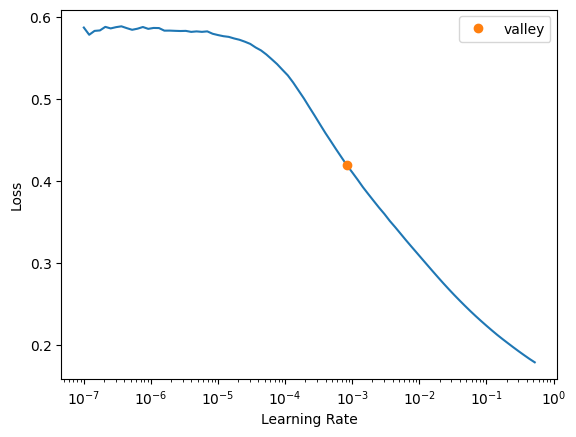

In [191]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.162349,0.167269,0.078162,00:00
1,0.107360,0.146016,0.180476,00:00
2,0.074040,0.095090,0.538074,00:00
3,0.051136,0.034431,0.910097,00:00
4,0.036539,0.014865,0.943308,00:00
5,0.026894,0.010049,0.947333,00:00
6,0.020224,0.009302,0.951359,00:00
7,0.015454,0.009791,0.952030,00:00
8,0.011948,0.009799,0.953707,00:00
9,0.009320,0.009927,0.952700,00:00


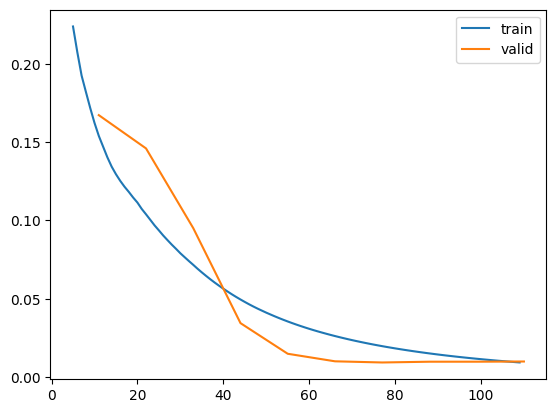

In [192]:
learn.fit(10, 1e-3, wd=0.01)
learn.recorder.plot_loss()

In [193]:
test_df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
test_df = test_df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
test_df = test_df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in test_df.columns:
    if test_df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(test_df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
test_df = test_df.explode(l)
test_df = test_df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
#print(df['Pathway(ConsensusPathDB)'].apply(lambda x: len(x) if type(x) is list else list()))
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.dropna(axis='columns', thresh=int(len(test_df.index)*0.8), inplace=True)
test_df = test_df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in test_df.columns:
    if test_df[col].map(lambda x: True if type(x) is list else False).any():
        #print(df[col])
        l1.append(col)

for col in l1:
    v = test_df[col].explode().value_counts()
    toRemove = v[v < int(len(test_df[col].explode()) * 0.10)].index
    test_df[col] = test_df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = test_df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

""" df_ex = pd.DataFrame.from_dict(dict, orient='index')
df_ex.columns = ['Valori unici', 'Esempi']
df_ex """

test_df.drop(['HPO_id', 'HPO_name', 'MGI_mouse_phenotype'], axis=1, inplace=True)
#dict.pop('Function_description')
#dict.pop('Disease_description')
dict.pop('HPO_id')
dict.pop('HPO_name')
dict.pop('MGI_mouse_phenotype')

for key, value in dict.items():
    if value['Valori unici'] > 10:
        test_df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(test_df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            test_df[c] = test_df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        test_df.drop(key, axis=1, inplace=True)
        

#dfi.export(df_ex, 'df_ex.png', table_conversion = "matplotlib")
#print(l1)
#MutationTaster_score and MGI_mouse_phenotype
#df['MutationTaster_score'] = df['MutationTaster_score'].apply(lambda x: np.mean([float(numeric_string) for numeric_string in x]) if type(x) is list else x)
#v = sorted(df['MGI_mouse_phenotype'].explode().unique())
#for c in v:
    #df[c] = df['MGI_mouse_phenotype'].apply(lambda lis: int(c in lis))
#df.drop(['MGI_mouse_phenotype', ' '], axis=1, inplace=True)

/tmp/ipykernel_660/2754477037.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [201]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'drug_response'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'association'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Affects'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'other'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.14125899970531464,0.607192873954773]

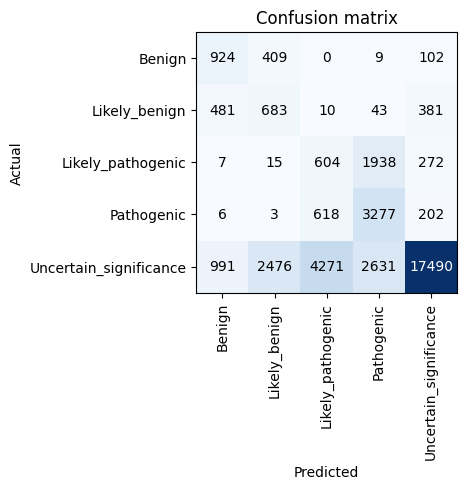

In [202]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()